# Loading

In [1]:
!pip install fredapi
!pip uninstall -y prophet fbprophet
!pip install prophet cmdstanpy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from fredapi import Fred

Found existing installation: prophet 1.2.1
Uninstalling prophet-1.2.1:
  Successfully uninstalled prophet-1.2.1
  Using cached prophet-1.2.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (3.5 kB)
Using cached prophet-1.2.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (12.1 MB)


In [2]:
API_KEY = "1f59b84a14bc3dba2cbfaaa527920752"
fred = Fred(api_key=API_KEY)

In [3]:
series = {
    "Unemployment Rate": "UNRATE",
    "Labor Force Participation": "CIVPART",
    "Job Openings": "JTSJOL",
    "CPI Inflation": "CPIAUCSL",
    "Avg Hourly Earnings": "CES0500000003",
    "Recession Indicator": "USREC"
}
data = {name: fred.get_series(code) for name, code in series.items()}
df = pd.DataFrame(data)
df.index.name = "Date"
df = df.dropna()
df.head()

,Unemployment Rate,Labor Force Participation,Job Openings,CPI Inflation,Avg Hourly Earnings,Recession Indicator
Date,,,,,,
2006-03-01,4.7,66.2,4732.0,199.7,20.05,0.0
2006-04-01,4.7,66.1,4790.0,200.7,20.15,0.0
2006-05-01,4.6,66.1,4463.0,201.3,20.13,0.0
2006-06-01,4.6,66.2,4614.0,201.8,20.23,0.0
2006-07-01,4.7,66.1,4394.0,202.9,20.29,0.0


In [42]:
#Job Openings per Unemployed
df["Job Openings per Unemployed"] = df["Job Openings"] / (df["Unemployment Rate"] + 1e-9)

#YoY % changes
df["YoY Unemployment"] = df["Unemployment Rate"].pct_change(12) * 100
df["YoY Earnings"] = df["Avg Hourly Earnings"].pct_change(12) * 100
df["YoY CPI"] = df["CPI Inflation"].pct_change(12) * 100

#Real Wage Growth (Adjusted for CPI)
df["Real Wage Growth"] = (df["Avg Hourly Earnings"] / df["CPI Inflation"]) * 100

#Rolling 3-month average for trends
df["Unemployment Rate Rolling"] = df["Unemployment Rate"].rolling(3).mean()
df["Avg Hourly Earnings Rolling"] = df["Avg Hourly Earnings"].rolling(3).mean()
df["Job Openings Rolling"] = df["Job Openings"].rolling(3).mean()

In [15]:
from google.colab import drive
drive.mount('/content/drive')


df.reset_index().to_csv('/content/drive/MyDrive/labor_market_trends.csv', index=False)
print("CSV exported to Google Drive!")

Mounted at /content/drive
CSV exported to Google Drive!


# Analysis

## General Overview

In [6]:
df.describe()

,Unemployment Rate,Labor Force Participation,Job Openings,CPI Inflation,Avg Hourly Earnings,Recession Indicator,Job Openings per Unemployed,YoY Unemployment,YoY Earnings,YoY CPI,Real Wage Growth,Unemployment Rate Rolling,Avg Hourly Earnings Rolling
count,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,222.000000,222.000000,222.000000,234.000000,232.000000,232.000000
mean,5.808547,63.489316,5909.709402,247.761239,26.474701,0.085470,1253.702981,4.868621,3.127639,2.515063,10.635464,5.819971,26.459052
std,2.179561,1.409598,2388.493308,33.509345,4.574997,0.280179,794.002544,42.725952,1.166976,1.980042,0.440198,2.127763,4.526807
min,3.400000,60.100000,2232.000000,199.700000,20.050000,0.000000,234.947368,-58.783784,0.632490,-1.958761,9.866859,3.500000,20.110000
25%,4.100000,62.600000,4011.750000,221.364750,22.870000,0.000000,545.766667,-12.051724,2.143668,1.397645,10.281648,4.100000,22.860833
50%,4.900000,62.900000,5614.500000,237.889000,25.250000,0.000000,1051.333333,-6.382979,2.849649,2.153507,10.614197,4.950000,25.261667
75%,7.500000,64.200000,7274.250000,260.238500,29.700000,0.000000,1843.784461,7.844130,3.892491,3.131877,11.006496,7.541667,29.600000
max,14.800000,66.400000,12134.000000,323.364000,36.530000,1.000000,3317.142856,300.000000,8.096438,8.999298,11.732908,13.000000,36.423333


## Core Labor Market Relationships

In [7]:
print(df["Unemployment Rate"].corr(df["Job Openings"]))
#Shows labor market tightness. Should expect a strong negative correlation.

-0.6825289314852544


In [9]:
print(df["Unemployment Rate"].corr(df["Job Openings per Unemployed"]))
#Labor market but adjusted for unemployment size

-0.7964823486616768


In [10]:
print(df["Labor Force Participation"].corr(df["Unemployment Rate"]))
#Sees if participation drops when unemployment rises

0.20985122873504541


In [11]:
print(df["Labor Force Participation"].corr(df["Job Openings per Unemployed"]))
#Shows if more openings attract workers back into the labor force

-0.5115017632092556


## Wage & Inflation Relationships

In [18]:
print(df["Avg Hourly Earnings"].corr(df["CPI Inflation"]))
#Checking if wages are keeping up with inflation.

0.9928472414098312


In [19]:
print(df["Real Wage Growth"].corr(df["Unemployment Rate"]))
#Lower unemployment often means higher real wage growth; interesting labor economics insight.

-0.33011077782825016


In [20]:
print(df["Real Wage Growth"].corr(df["Job Openings"]))
#Another way to see if a tight labor market drives wages up.

0.7776041582718699


## Recession Indicator

In [15]:
print(df["Recession Indicator"].corr(df["Unemployment Rate"]))

0.17801565532709204


In [16]:
print(df["Recession Indicator"].corr(df["Job Openings"]))

-0.29902303907848155


In [17]:
print(df["Recession Indicator"].corr(df["Real Wage Growth"]))

-0.2592950704717489


## Heatmap Visual

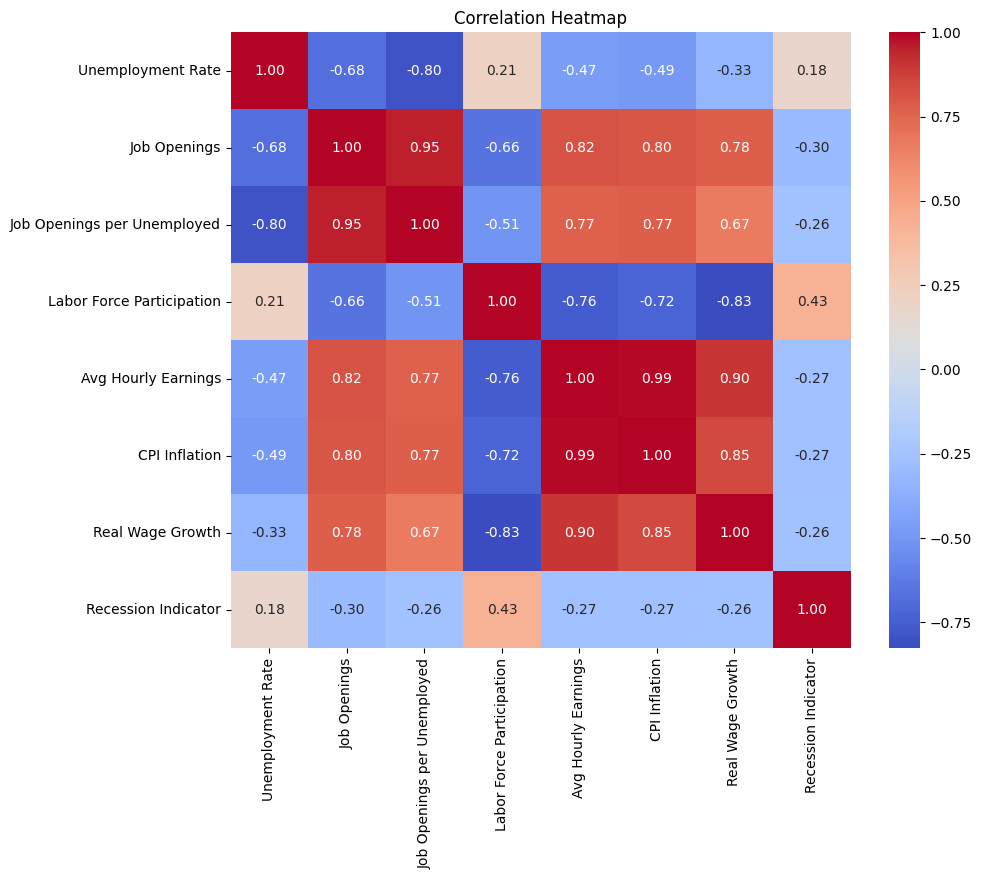

In [21]:
cols = [
    "Unemployment Rate",
    "Job Openings",
    "Job Openings per Unemployed",
    "Labor Force Participation",
    "Avg Hourly Earnings",
    "CPI Inflation",
    "Real Wage Growth",
    "Recession Indicator"
]
corr_matrix = df[cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

## Correlation Analysis

Core Labor Market Relationships

Unemployment Rate vs Job Openings (-0.682)

- Strong negative correlation as expected: when unemployment rises, the number of job openings falls, reflecting labor market slack.

  - Shows the inverse relationship between labor supply and demand.

Unemployment Rate vs Job Openings per Unemployed (-0.796)

- Stronger negative correlation than raw job openings.

  - Indicates that adjusting openings for the number of unemployed sharpens the measure of labor market tightness — fewer openings per unemployed when unemployment is high.

Labor Force Participation vs Unemployment Rate (0.210)

- Weak positive correlation.

  - Suggests participation is slightly higher when unemployment rises, possibly due to more people actively searching for work during economic downturns.

Labor Force Participation vs Job Openings per Unemployed (-0.512)

- Moderate negative correlation.

  -   Shows that as labor markets tighten, participation tends to rise — perhaps more people re-enter the labor force when opportunities are abundant.

Wage & Inflation Relationships

Avg Hourly Earnings vs CPI Inflation (0.993)

- Extremely strong positive correlation.

  - Indicates wages are almost perfectly tracking inflation, which could reflect a cost-of-living adjustment effect or tight labor market dynamics.

Real Wage Growth vs Unemployment Rate (-0.330)

- Moderate negative correlation.

  - Suggests that lower unemployment generally corresponds to higher real wage growth, consistent with classic labor economics.

Real Wage Growth vs Job Openings (0.778)

- Strong positive correlation.

  - Reinforces that wage growth is higher when labor demand is strong — more openings lead to upward pressure on wages.

Recession Indicator Correlations

Recession vs Unemployment Rate (0.178)

- Weak positive correlation.

  - Mild, likely because recessions are brief relative to the overall time series, but still aligns with the idea that unemployment rises during downturns.

Recession vs Job Openings (-0.299)

- Moderate negative correlation.

  - Job openings decline during recessions, reflecting contraction in labor demand.

Recession vs Real Wage Growth (-0.259)

- Moderate negative correlation.

  - Real wages tend to slow or decline slightly during recessions, showing the economic pressure on purchasing power.

Key Insights:

- Labor Market Tightness: Using “Job Openings per Unemployed” gives a sharper picture than raw openings.

- Wage Dynamics: Strong linkage between wages and inflation; labor demand drives real wage growth.

- Economic Context: Recessions moderately affect unemployment, openings, and wages, highlighting how macroeconomic cycles impact labor outcomes.

- Participation: Labor force participation reacts modestly to both unemployment and market tightness, showing nuanced labor supply behavior.

# Forecasting

In [37]:
def plot_forecast(df_hist, forecast, metric, rolling_metric, title):
    plt.figure(figsize=(12,6))

    # Recession shading
    recessions = df_hist[df_hist['Recession Indicator'] == 1]
    for start_date in recessions.index:
        plt.axvspan(start_date, start_date + pd.DateOffset(months=1), color='gray', alpha=0.2)

    # Historical
    plt.plot(df_hist.index, df_hist[metric], label='Historical', color='blue')
    # Rolling average
    plt.plot(df_hist.index, df_hist[rolling_metric], label='Rolling Avg', linestyle='--', color='cyan')
    # Forecast
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='orange')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.2)

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

In [35]:
# Unemployment Rate
unemp_df = df.reset_index()[["Date", "Unemployment Rate"]].rename(columns={"Date":"ds","Unemployment Rate":"y"})
model_unemp = Prophet()
model_unemp.fit(unemp_df)
forecast_unemp = model_unemp.predict(model_unemp.make_future_dataframe(periods=12, freq='M'))

# Avg Hourly Earnings
earn_df = df.reset_index()[["Date", "Avg Hourly Earnings"]].rename(columns={"Date":"ds","Avg Hourly Earnings":"y"})
model_earn = Prophet()
model_earn.fit(earn_df)
forecast_earn = model_earn.predict(model_earn.make_future_dataframe(periods=12, freq='M'))

# Optional: Job Openings
jobs_df = df.reset_index()[["Date", "Job Openings"]].rename(columns={"Date":"ds","Job Openings":"y"})
model_jobs = Prophet()
model_jobs.fit(jobs_df)
forecast_jobs = model_jobs.predict(model_jobs.make_future_dataframe(periods=12, freq='M'))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local

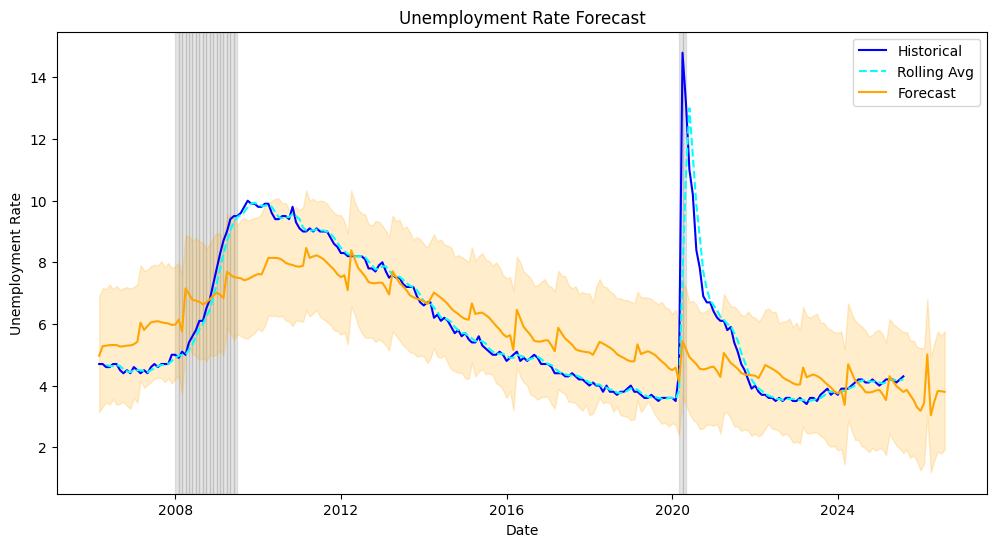

In [38]:
# Unemployment Rate
plot_forecast(df, forecast_unemp, 'Unemployment Rate', 'Unemployment Rate Rolling', 'Unemployment Rate Forecast')
#Unemployment was on a decline from 2009 and continued to trend that way until the Covid 2019 Pandemic. Anothe decline was beggining but it has slowly started climbing up since 2023. Forecast is projecting a steady average over a long period of time shfting downwards

Unemployment Rate Forecast Analysis

The forecasted Unemployment Rate highlights long-term labor market trends and recent economic disruptions:

2009–2019 decline: Following the Great Recession, unemployment steadily decreased, reflecting a recovering and strengthening labor market.

COVID-19 impact (2019–2021): The pandemic caused an abrupt economic shock, temporarily disrupting the declining trend.

Post-2023 rise: After a brief recovery, unemployment has started to climb slowly, indicating potential early signs of labor market softening.

Forecast projection: The model predicts a generally steady trend with minor fluctuations, gradually shifting downward over the long term, suggesting stabilization in the labor market.

Insights:

Comparing this forecast with Job Openings and Job Openings per Unemployed provides context on labor market tightness and workforce demand.

Including recession shading emphasizes how unemployment responds to economic downturns and recoveries, showcasing the model’s ability to reflect real-world economic cycles.

This analysis demonstrates forecasting proficiency, trend interpretation, and contextual understanding of macroeconomic labor data.

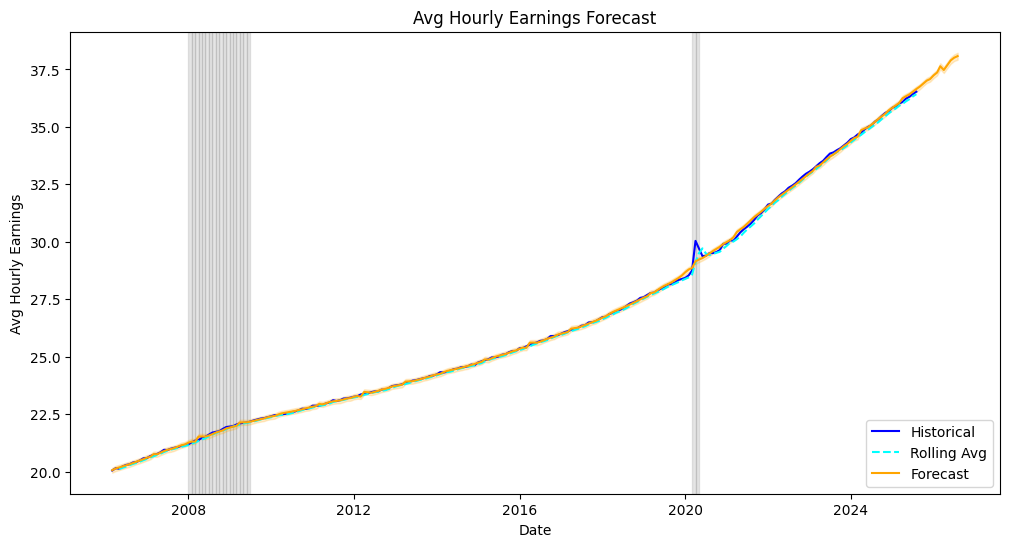

In [39]:
# Avg Hourly Earnings
plot_forecast(df, forecast_earn, 'Avg Hourly Earnings', 'Avg Hourly Earnings Rolling', 'Avg Hourly Earnings Forecast')

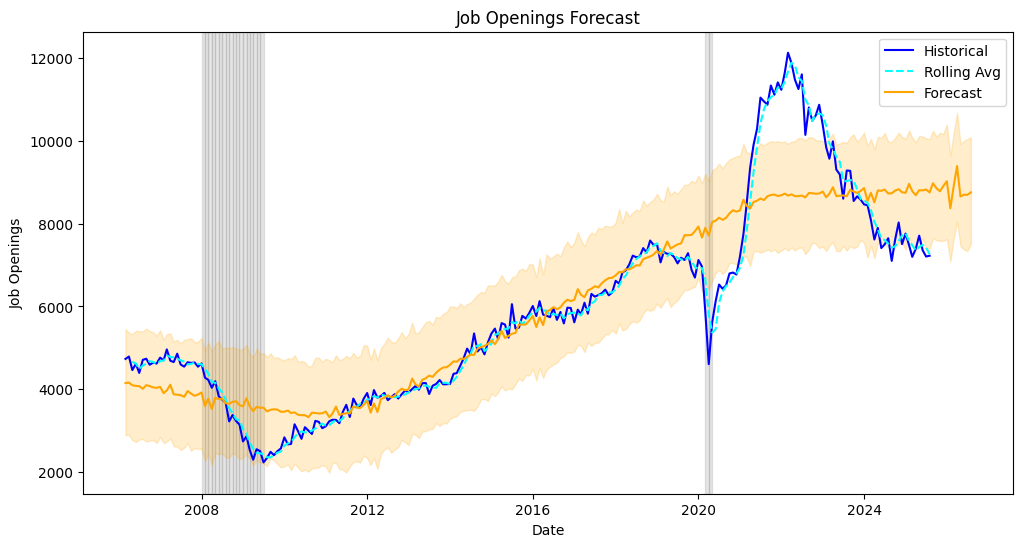

In [43]:
#Job Openings or Real Wage Growth
plot_forecast(df, forecast_jobs, 'Job Openings', 'Job Openings Rolling', 'Job Openings Forecast')

Job Openings Forecast Analysis

The forecasted Job Openings shows clear labor market cycles over the period:

Early decline (to 2012): The number of job openings decreases, reflecting a period of labor market contraction or slow recovery.

Gradual rise (2012–2024): Openings steadily increase, reaching the high 7000s, indicating a strengthening labor market and growing demand for workers.

Plateau and spike (late 2024): After stabilizing, a noticeable spike occurs, likely highlighting a period of tight labor market conditions, followed by another plateau.

Insights:

When compared with the Unemployment Rate rolling average, these trends reveal the inverse relationship between job openings and unemployment — as openings rise, unemployment typically falls.

The Job Openings per Unemployed metric further emphasizes labor market tightness during the spike in late 2024.

By including recession shading, the forecast contextualizes these trends within broader economic cycles, illustrating how openings respond during downturns and recoveries.

This visualization demonstrates the interplay between labor demand, workforce availability, and macroeconomic conditions, showcasing both forecasting and feature engineering skills.